# 层次聚类-聚合聚类

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=16)

In [4]:
Y =  np.array([
    [0, 0, 1],
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
    
])
W = np.arange(16).reshape(4, 4)
Y.T @ W @ Y

array([[15, 13, 26],
       [ 7,  5, 10],
       [14, 10, 20]])

In [6]:
Y[0].shape

(3,)

In [ ]:
data = np.loadtxt('testSet2.txt')
data

In [ ]:
plt.scatter(data[:, 0], data[:, 1])

In [ ]:
a = np.arange(10).reshape(10, 1).tolist()
a

In [ ]:
from itertools import combinations

class AgglomerativeCluster:
    def __init__(self, n_clusters=3, linkage_type='average'):
        self.n_clusters = n_clusters
        self.linkage_type = linkage_type
    
    def get_linkage(self, cluster_1, cluster_2):
        if self.linkage_type == 'single':  # 最短
            linkage = np.inf
            for sample_1 in cluster_1:
                for sample_2 in cluster_2:
                    distance = self.distances[sample_1, sample_2]
                    if distance < linkage:
                        linkage = distance
        elif self.linkage_type == 'complete':  # 最长
            linkage = 0
            for sample_1 in cluster_1:
                for sample_2 in cluster_2:
                    distance = self.distances[sample_1, sample_2]
                    if distance > linkage:
                        linkage = distance
        elif self.linkage_type == 'average':  # 平均距离
            distances = []
            for sample_1 in cluster_1:
                for sample_2 in cluster_2:
                    distance = self.distances[sample_1, sample_2]
                    distances.append(distance)
            linkage = np.mean(distances)
        else:  # 方差最小化
            pass
        return linkage
    
    
    def clustering(self, clusters):
        while True:
            combins = [c for c in combinations(range(len(clusters)), 2)]
            linkages = [self.get_linkage(clusters[c[0]], clusters[c[1]]) for c in combins]
            # 类间距最小的2个类
            min_arg = combins[np.argmin(linkages)]
            # 合并距离最短的2个簇
            clusters.append(clusters[min_arg[0]] + clusters[min_arg[1]])
            
            # 注意list pop的顺序 先后再前
            clusters.pop(max(min_arg))
            clusters.pop(min(min_arg))
            if len(clusters) == self.n_clusters:
                break
        return clusters
    
    def fit(self, X):
        n_samples, n_features = X.shape
        # 相同簇的样本放在同一个子list中
        clusters = np.arange(n_samples).reshape(n_samples, 1).tolist()
        self.labels_ = np.zeros(n_samples, dtype=int)
        
        # d_{ij} 样本X_i 与 X_j 间距
        self.distances = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            self.distances[i, :] = np.sqrt(np.sum(np.square(X[i] - X[:]), axis=1))
        # 聚合聚类   
        self.clusters = self.clustering(clusters)
        
        # 聚类结果转成labels的形式
        for c in range(len(self.clusters)):
            for i in clusters[c]:
                self.labels_[i] = c
    
    def predict(self, X):
        pass

In [ ]:
clf = AgglomerativeCluster(3, linkage_type='average')
clf.fit(data)

In [ ]:
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(data[clf.labels_==i, 0], data[clf.labels_==i, 1], color=colors[i])

## AgglomerativeClustering

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering

In [ ]:
iris = load_iris()
X = iris.data
X_std = scale(X)

In [ ]:
clf = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=3)
clf.fit(X_std)

需要注意的参数:
- affinity: Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. default: “euclidean”
- linkage: Which linkage criterion to use. [{“ward”, “complete”, “average”, “single”}, optional (default=”ward”)]

In [ ]:
clf.labels_

# MeanShift 均值移动聚类
---
MeanShift 算法旨在于发现一个样本密度平滑的 blobs 。均值漂移(Mean Shift)算法是基于质心的算法，通过更新质心的候选位置，这些侯选位置通常是所选定区域内点的均值。然后，这些候选位置在后处理阶段被过滤以消除近似重复，从而形成最终质心集合。

给定第$ t $次迭代中的候选质心$ x_i$ , 候选质心的位置将被按照如下公式更新:

$$x_i^{t+1} = x_i^t + m(x_i^t)$$

其中$ N(x_i) $是围绕$ x_i $周围一个给定距离范围内的样本邻域, m 是均值偏移向量(mean shift vector), 该向量是所有质心中指向 点密度增加最多的区域的偏移向量。使用以下等式计算，有效地将质心更新为其邻域内样本的平均值:

$$m(x_i) = \frac{\sum_{x_j \in N(x_i)}K(x_j - x_i)x_j}{\sum_{x_j \in N(x_i)}K(x_j - x_i)}$$

算法自动设定聚类的数目，而不是依赖参数 带宽（bandwidth）,带宽是决定搜索区域的size的参数。 这个参数可以手动设置，但是如果没有设置，可以使用提供的函数 estimate_bandwidth 获取 一个估算值。

该算法不是高度可扩展的，因为在执行算法期间需要执行多个最近邻搜索。 该算法保证收敛，但是当 质心的变化较小时，算法将停止迭代。

通过找到给定样本的最近质心来给新样本打上标签。

MeanShift有两个我们应该注意的重要参数。 首先，`bandwidth`设置区域（即观测核）半径，用于确定移动方向。 在我们的比喻中，带宽是一个人可以在雾中看到的距离。 我们可以手动设置此参数，但默认情况下会自动估算合理的带宽（计算成本会显着增加）。 其次，有时在均值移动中，观测核中没有其他观测结果。 也就是说，我们足球上的一个人看不到任何其它人。 默认情况下，MeanShift将所有这些“孤例”观测值分配给最近观测核。 但是，如果我们想要留出这些孤例，我们可以设置`cluster_all = False`，其中孤例观测标签为 -1。

A demo of the mean-shift clustering algorithm

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print('centers: ', cluster_centers)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(12, 10))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
        markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# DBSCN
---
DBSCAN 算法将簇视为被低密度区域分隔的高密度区域。由于这个相当普遍的观点， DBSCAN发现的簇可以是任何形状的，与假设簇是凸的 K-means 相反。 DBSCAN 的核心概念是 core samples, 是指位于高密度区域的样本。 因此一个簇是一组核心样本，每个核心样本彼此靠近（通过某个距离度量测量） 和一组接近核心样本的非核心样本（但本身不是核心样本）。算法中的两个参数, min_samples 和 eps,正式的定义了我们所说的 稠密（dense）。较高的 min_samples 或者较低的 eps 都表示形成簇所需的较高密度。

更正式的,我们定义核心样本是指数据集中的一个样本的 eps 距离范围内，存在 min_samples 个其他样本，这些样本被定为为核心样本的邻居( neighbors) 。这告诉我们，核心样本在向量空间的稠密区域。一个簇是一个核心样本的集合，可以通过递归来构建，选取一个核心样本，查找它所有的邻居样本中的核心样本，然后查找新获取的核心样本的邻居样本中的核心样本，递归这个过程。 簇中还具有一组非核心样本，它们是簇中核心样本的邻居的样本，但本身并不是核心样本。 显然，这些样本位于簇的边缘。

根据定义，任何核心样本都是簇的一部分，任何不是核心样本并且和任意一个核心样本距离都大于eps 的样本将被视为异常值。

当参数min_samples 主要表示算法对噪声的容忍度(当处理大型噪声数据集时, 需要考虑增加该参数的值), 针对具体地数据集和距离函数，参数eps 如何进行合适地取值是非常关键，这通常不能使用默认值。参数eps控制了点地领域范围。如果取值太小,大部分地数据并不会被聚类(被标注为 -1 代表噪声); 如果取值太大，可能会 导致 相近 的多个簇被合并成一个,甚至整个数据集都被分配到一个簇。

- eps: 邻域, 观测到被认为是邻居的另一个观测的最大距离
- min_samples: 小于上面的eps距离的最小观测数量
- metric: eps使用的距离度量。 例如，minkowski，euclidean等（请注意，如果使用 Minkowski 距离，参数p可用于设置 Minkowski 度量的指数）

Demo of DBSCAN clustering algorithm

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


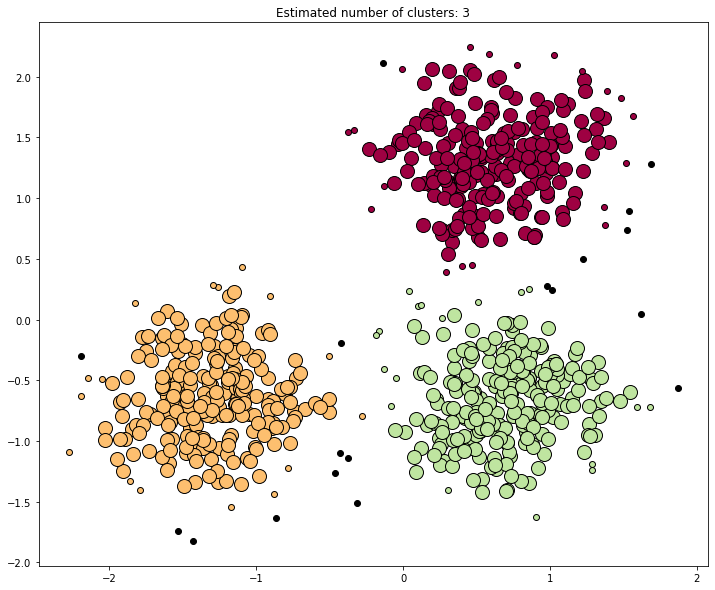

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # 分类-1 表示噪声
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"% metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels,
    average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]  # 核心点
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]  # 非核心点
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# 使用高斯混合模型的概率聚类

In [2]:
# 创建一些数据 模拟女性和男性的身高
N = 1000
in_m = 72
in_w = 66

s_m = 2
s_w = 2
m = np.random.normal(in_m, s_m, N)
w = np.random.normal(in_w, s_w, N)

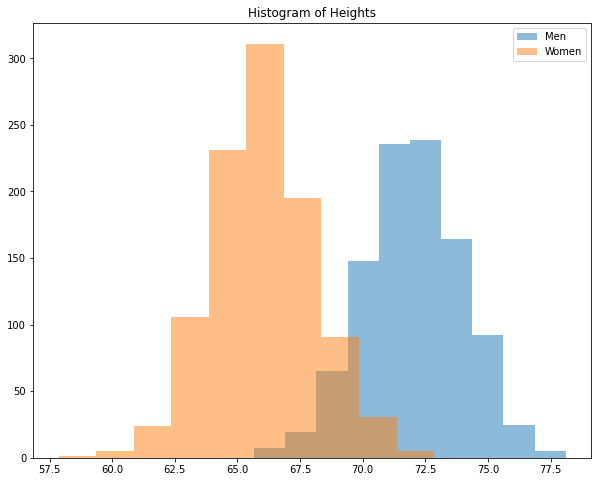

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Histogram of Heights")
plt.hist(m, alpha=.5, label='Men')
plt.hist(w, alpha=.5, label='Women')
plt.legend()

In [4]:
# 对分组二次抽样，训练分布，之后预测剩余分组
random_sample = np.random.choice([True, False], size=m.size) 
m_test = m[random_sample] 
m_train = m[~random_sample]

w_test = w[random_sample] 
w_train = w[~random_sample] 

In [5]:
# 需要获得男性和女性高度的经验分布，基于训练集：
from scipy import stats

m_pdf = stats.norm(m_train.mean(), m_train.std()) 
w_pdf = stats.norm(w_train.mean(), w_train.std()) 

In [6]:
m_pdf.pdf(m[0]) 

0.1802776878882602

In [7]:
w_pdf.pdf(m[0]) 

0.007960976953496913

In [8]:
# 假设当男性的概率更高时，我们会猜测，但是如果女性的概率更高，我们会覆盖它。
guesses_m = np.ones_like(m_test) 
guesses_m[m_pdf.pdf(m_test) < w_pdf.pdf(m_test)] = 0
guesses_m

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
# 准确度
guesses_m.mean() 

0.9176706827309237

In [10]:
# 女性分组
guesses_w = np.ones_like(w_test)
guesses_w[m_pdf.pdf(w_test) > w_pdf.pdf(w_test)] = 0
guesses_w.mean()

0.9317269076305221

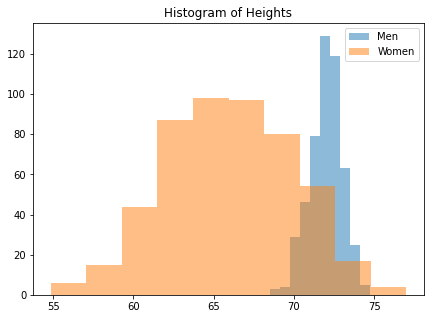

In [11]:
# 方差不相同时
s_m = 1 
s_w = 4

m = np.random.normal(in_m, s_m, N) 
w = np.random.normal(in_w, s_w, N) 

m_test = m[random_sample] 
m_train = m[~random_sample]

w_test = w[random_sample] 
w_train = w[~random_sample] 
f, ax = plt.subplots(figsize=(7, 5)) 
ax.set_title("Histogram of Heights") 
ax.hist(m_train, alpha=.5, label="Men"); 
ax.hist(w_train, alpha=.5, label="Women"); 
ax.legend() 

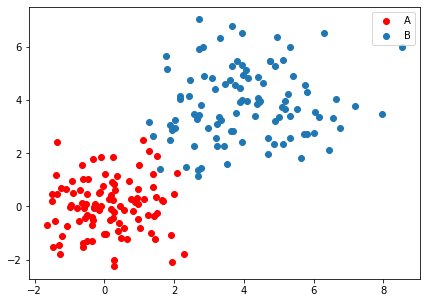

In [12]:
class_A = np.random.normal(0, 1, size=(100, 2)) 
class_B = np.random.normal(4, 1.5, size=(100, 2)) 
f, ax = plt.subplots(figsize=(7, 5))

ax.scatter(class_A[:,0], class_A[:,1], label='A', c='r')
ax.scatter(class_B[:,0], class_B[:,1], label='B')
plt.legend()

In [13]:
X = np.vstack((class_A, class_B))
X

array([[-0.3325,  1.7979],
       [ 1.6466,  0.2571],
       [-0.1396,  0.5148],
       ...,
       [ 3.9693,  4.957 ],
       [ 4.4146,  4.102 ],
       [ 6.0519,  3.5489]])

In [14]:
y = np.hstack((np.ones(100), np.zeros(100)))
y

array([1., 1., 1., ..., 0., 0., 0.])

In [16]:
from sklearn.mixture import GaussianMixture 

train = np.random.choice([True, False], 200) 
gmm = GaussianMixture(n_components=2)
gmm.fit(X[train])

GaussianMixture(n_components=2)

In [17]:
# 权重
gmm.weights_

array([0.5403, 0.4597])

In [18]:
# 均值
gmm.means_

array([[0.0846, 0.0417],
       [3.8153, 3.7983]])

In [19]:
# 方差
gmm.covariances_

array([[[ 0.9911, -0.0626],
        [-0.0626,  0.8304]],

       [[ 3.0388,  0.5289],
        [ 0.5289,  2.2276]]])

In [20]:
gmm.precisions_

array([[[ 1.0138,  0.0765],
        [ 0.0765,  1.21  ]],

       [[ 0.3433, -0.0815],
        [-0.0815,  0.4683]]])

In [21]:
labels_ = gmm.predict(X)

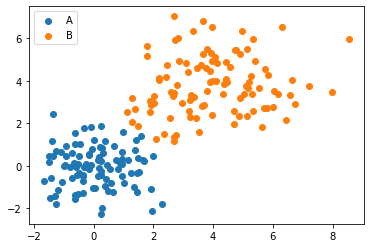

In [22]:
labels = ['A', 'B']
for i in range(2):
    k = labels_ == i
    plt.scatter(X[k, 0], X[k, 1], label=labels[i])
plt.legend()